# Exploring Insight Data Science Fellows

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from collections import Counter
import re
import itertools
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# 0. Scrape and format list of Insight data fellows

In [2]:
# Request web page
page = requests.get('https://www.insightdatascience.com/fellows')

# Parse HTML and get Tag element
soup = BeautifulSoup(page.content, 'html.parser')
html = list(soup.children)[2]

# Define classes of interest
class_names = {'name': 'tooltip_name',
               'title': 'toottip_title',
               'company': 'tooltip_company',
               'insight_project': 'tooltip_project',
               'background': 'tooltip_background'}

# Make dataframe of fellow information
class_htmls = {k:soup.find_all('div', class_=v) for (k,v) in class_names.items()}
df_fellows = pd.DataFrame({k: [class_htmls[k][i].get_text() for i in range(len(class_htmls[k]))] for k in class_names.keys()})

# Parse academic background
# NOTE: parsing of academic information is not possible in some cases because of inconsistencies in string formatting
df_fellows['N_commas'] = [s.count(',') for s in df_fellows['background']]
df_fellows['academic_field'] = np.nan
df_fellows['academic_institute'] = np.nan
df_fellows['academic_position'] = np.nan
df_fellows.loc[df_fellows['N_commas']==2, 'academic_field'] = [x.split(',')[0].strip() for x in df_fellows.loc[df_fellows['N_commas']==2, 'background']]
df_fellows.loc[df_fellows['N_commas']==2, 'academic_institute'] = [x.split(',')[1].strip() for x in df_fellows.loc[df_fellows['N_commas']==2, 'background']]
df_fellows.loc[df_fellows['N_commas']==2, 'academic_position'] = [x.split(',')[2].strip() for x in df_fellows.loc[df_fellows['N_commas']==2, 'background']]

# List of affiliations that could not be parsed (uncommon comma structure)
backgrounds_unparsed = df_fellows.loc[df_fellows['N_commas']!=2]['background'].values

# Misc formatting
df_fellows.drop('N_commas', axis=1, inplace=True)
df_fellows['title'] = [x.strip() for x in df_fellows['title']]

# Rename some institutes that are duplicates that occur more than once
institute_renames = {'Stanford University': 'Stanford',
                     'Harvard University': 'Harvard',
                     'Harvard-Smithsonian Center for Astrophysics': 'Harvard',
                     'Harvard Medical School': 'Harvard',
                     'Columbia University': 'Columbia',
                     'Princeton University': 'Princeton',
                     'Yale University': 'Yale',
                     'New York University': 'NYU',
                     'UCSD': 'UC San Diego',
                     'University of California - San Diego': 'UC San Diego',
                     'UCSF': 'UC San Francisco',
                     'UCSB': 'UC Santa Barbara',
                     'UCSC': 'UC Santa Cruz',
                     'University of Texas at Austin': 'UT Austin',
                     'Massachusetts Institute of Technology': 'MIT',
                     'California Institute of Technology': 'Caltech',
                     'Georgia Institute of Technology': 'Georgia Tech'}
df_fellows['academic_institute'] = df_fellows['academic_institute'].replace(institute_renames)

### Clump academic fields

In [3]:
def clump_col(value, kws, order, default):
    if isinstance(value, float):
        return np.nan
    value = value.lower()
    
    for val_check in order:
        if any(x in value for x in kws[val_check]):
            return val_check
    return default

In [4]:
field_kws = {'Physics': ['physics', 'atoms', 'quantum'],
             'Engineering': ['engineering', 'mechanic', 'aeronaut', 'wireless communications'],
             'Neuroscience': ['neuro', 'cognitive', 'psych', 'neural', 'cognition', 'behavior'],
             'Math': ['mathematic', 'statistics', 'operations research', 'geometry'],
             'Comp bio': ['computational bio', 'bioinformatics', 'biostat', 'genomics',
                          'medical image', 'computational optics', 'bio-x games', 'image analysis',
                          'computational immunology', 'health informatics', 'biophys'],
             'Biology': ['biolog', 'genetics', 'biomed', 'molecular', 'evolution', 'clinical',
                         'epidemiology', 'life-sciences'],
             'Social sci': ['political sci', 'economics', 'linguistics', 'policy', 'sociol',
                                'politic', 'city & regional planning', 'education', 'architect',
                                'management', 'social science', 'business', 'english', 'urban data',
                                'decision analysis'],
             'Computer sci': ['computer', 'data sci', 'computing', 'machine learn'],
             'Other sci': ['astronomy', 'atmospheric', 'chemistry', 'ecology', 'space', 'ocean',
                               'materials', 'environment', 'cosmol', 'climate', 'radiology', 'water sci',
                               'planetary', 'energy', 'geosci', 'computational research division',
                               'department of innovation and technology']}
field_order = ['Comp bio', 'Physics', 'Engineering', 'Neuroscience', 'Math', 'Biology',
               'Social sci', 'Computer sci', 'Other sci']

df_fellows['field_clump'] = df_fellows['academic_field'].apply(clump_col, args=(field_kws, field_order, 'other'))

### Clump titles by seniority

In [5]:
title_kws = {'senior': ['senior', 'lead', 'sr.', 'director', 'principal', 'manager', 'head of', 'vp']}
title_order = ['senior']
df_fellows['seniority'] = df_fellows['title'].apply(clump_col, args=(title_kws, title_order, 'not senior'))

### Clump project types

In [6]:
field_kws = {'Twitter': ['twitter', 'tweet'],
             'Yelp': ['yelp', 'food', 'restaurant', 'eat']}
field_order = ['Twitter', 'Yelp']
df_fellows['project_field'] = df_fellows['insight_project'].apply(clump_col, args=(field_kws, field_order, 'other'))

method_kws = {'Recommend': ['recommend'],
              'Predict': ['predict'],
              'Find': ['find']}
method_order = ['Recommend', 'Predict', 'Find']
df_fellows['project_method'] = df_fellows['insight_project'].apply(clump_col, args=(method_kws, method_order, 'other'))

### Save formatted df

In [7]:
# Save fellows df
df_fellows.to_csv('/gh/data/misc/insightfellows_new.csv')
# df_fellows = pd.read_csv('/gh/data/misc/insightfellows_new.csv', index_col=0)

df_fellows.head()

,background,company,insight_project,name,title,academic_field,academic_institute,academic_position,field_clump,seniority,project_field,project_method
0,"Bio-X Games, Stanford, Postdoc",Capital One,Measuring the Impact of Open Source Coders on ...,JP Bida,Director of Risk,Bio-X Games,Stanford,Postdoc,Comp bio,senior,other,other
1,"Physics, Harvard University, PhD\n",Twitter,Email Searcher: Search & Visualize Your Mailbox,Douglas Mason,Data Scientist,Physics,Harvard,PhD,Physics,not senior,other,other
2,"Operations Research, MIT, PhD",Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Virot Ta Chiraphadhanakul,Data Scientist,Operations Research,MIT,PhD,Math,not senior,Twitter,other
3,"Statistics, Stanford, Postdoc",Adobe,Sentiment Analysis Based on Social Media,Julia Viladomat,Data Scientist,Statistics,Stanford,Postdoc,Math,not senior,other,other
4,"Mathematics, Stanford, Postdoc",LinkedIn,Flight Delay Predictor,David Freeman,Head of Anti-Abuse Engineering,Mathematics,Stanford,Postdoc,Math,senior,other,Predict


# 1. Companies that hire the most fellows

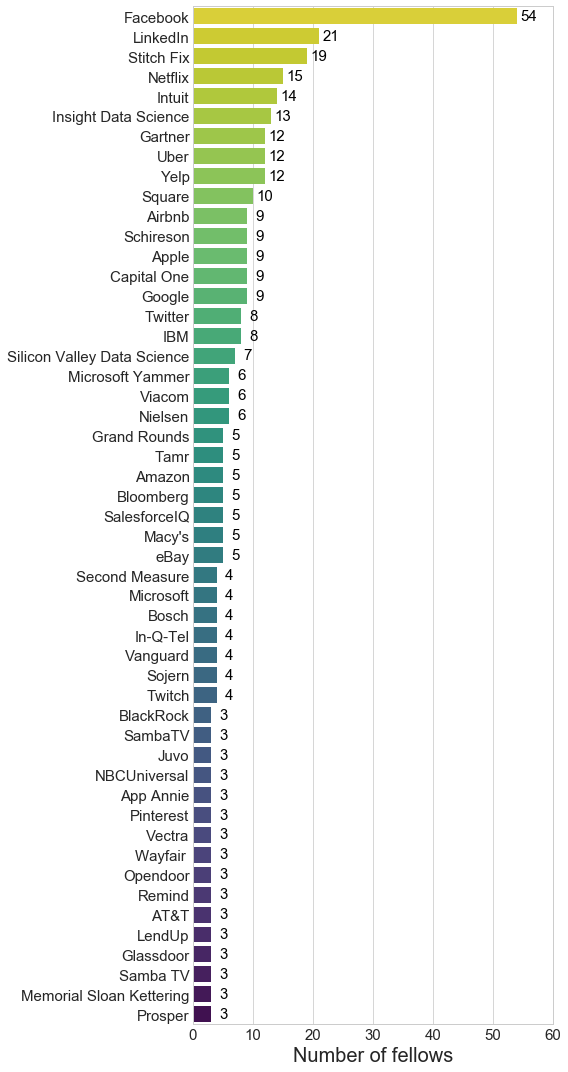

In [8]:
counts = df_fellows['company'].value_counts()
companies_keep = counts[counts>=3].index
df_plt = df_fellows[df_fellows['company'].isin(companies_keep)].copy()

plt.figure(figsize=(8,15))
g = sns.countplot(y='company', data=df_plt, order=companies_keep, palette='viridis_r')

valuecounts = pd.DataFrame(df_plt['company'].value_counts()).reset_index()
for index, row in valuecounts.iterrows():
    g.text(row['company'] + 2, row.name + .2,
           row['company'], color='black', ha="center", size=15)

plt.xlabel('Number of fellows', size=20)
plt.ylabel('')
plt.xticks(np.arange(0,70,10), size=15)
plt.yticks(size=15);
plt.tight_layout()
plt.savefig('/gh/srcole.github.io/assets/insightfellows/companies.png')

# 1b. Companies advertised by Insight

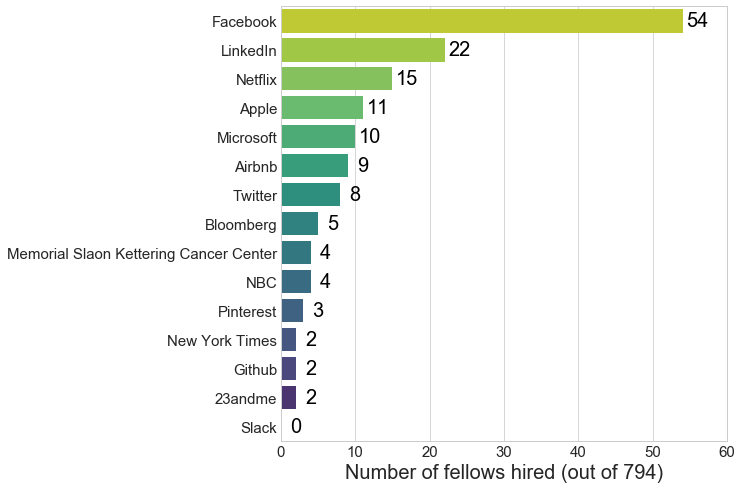

In [9]:
# Search for companies listed in advertisement for Insight
company_strs = {'Facebook': 'facebook',
                'LinkedIn': 'linkedin',
                'New York Times': 'new york times',
                'Apple': 'apple',
                'Airbnb': 'airbnb',
                'Netflix': 'netflix',
                'Memorial Slaon Kettering Cancer Center': 'sloan',
                'Github': 'github',
                'Slack': 'slack',
                '23andme': '23',
                'Twitter': 'twitter',
                'Bloomberg': 'bloomberg',
                'NBC': 'nbc',
                'Pinterest': 'pinterest',
                'Microsoft': 'microsoft'}
ad_N = []
for company, cstr in company_strs.items():
    ad_N.append(df_fellows['company'].str.lower().str.contains(cstr).sum())
df_ad = pd.DataFrame({'company': list(company_strs.keys()), 'N':ad_N})
df_ad = df_ad.sort_values(by='N', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,8))
g=sns.barplot(y='company', x='N', data=df_ad, palette='viridis_r')

for index, row in df_ad.iterrows():
    g.text(row['N'] + 2, row.name + .2, row['N'], color='black', ha="center", size=20)


plt.xlabel('Number of fellows hired (out of {:d})'.format(len(df_fellows)), size=20)
plt.ylabel('')
plt.xticks(np.arange(0,70,10), size=15)
plt.yticks(size=15);

# 2. Most common titles

In [10]:
# Note distribution of seniority
df_fellows['seniority'].value_counts()

not senior    650
senior        144
Name: seniority, dtype: int64

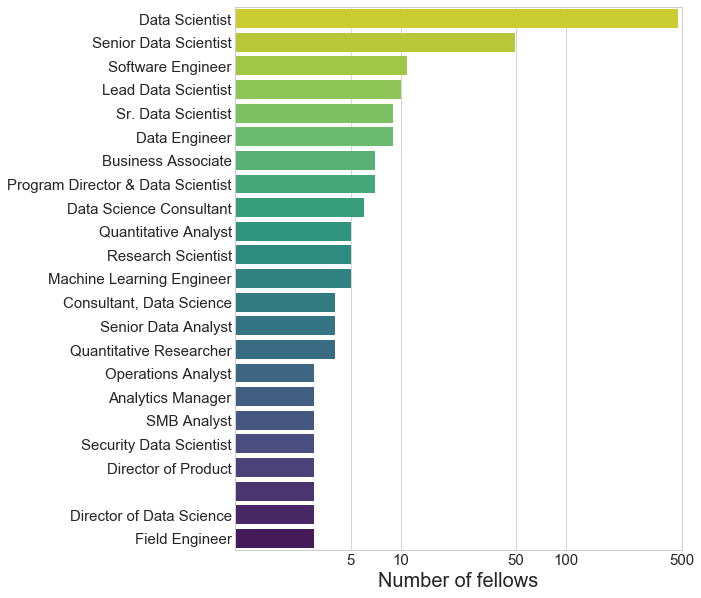

In [11]:
counts = df_fellows['title'].value_counts()
companies_keep = counts[counts>=3].index
df_plt = df_fellows[df_fellows['title'].isin(companies_keep)].copy()

plt.figure(figsize=(8,10))
g = sns.countplot(y='title', data=df_plt, order=companies_keep, palette='viridis_r')

plt.xlabel('Number of fellows', size=20)
plt.ylabel('')
plt.gca().set_xscale('log')
plt.xticks([5, 10, 50, 100, 500], [5, 10, 50, 100, 500], size=15)
plt.xlim((1, 500))
plt.yticks(size=15);

# 3. Most common fields of study

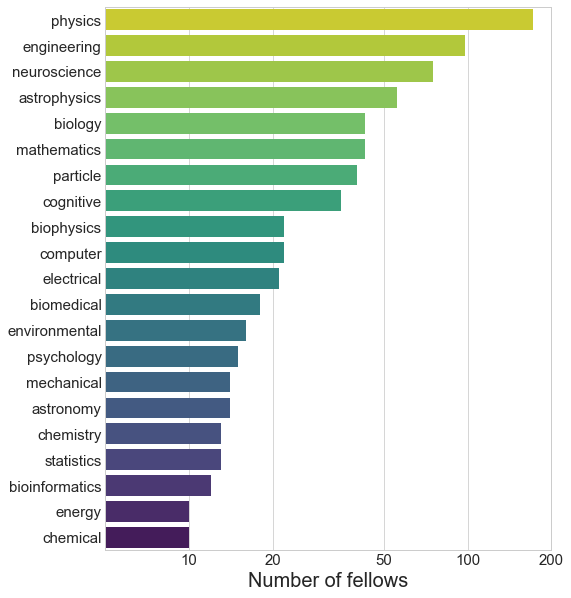

In [12]:
# Set parameters for defining fields
fields_rmv = ['nan', 'science', 'computational', 'and', 'applied',
              'experimental', 'systems', 'theoretical', 'sciences', 'mathematical']
min_field_N = 10

# Make dataframe of fields
all_fields = ' '.join(df_fellows['academic_field'].values.astype(str)).lower()
words = re.findall(r'\w+', all_fields)
c = Counter(words)
df_field_counts = pd.DataFrame(dict(c.items()), index=['count']).T
df_field_counts = df_field_counts[df_field_counts['count'] >= min_field_N]
df_field_counts.drop(fields_rmv, inplace=True)
df_plt = df_field_counts.reset_index().rename(columns={'index': 'field'})

# Make bar plot
plt.figure(figsize=(8,10))
sns.barplot(y='field', x='count', data=df_plt,
            order=df_plt.sort_values(by='count', ascending=False)['field'],
            palette='viridis_r')
plt.xlabel('Number of fellows', size=20)
plt.ylabel('')
plt.gca().set_xscale('log')
plt.xticks([10, 20, 50, 100, 200], [10, 20, 50, 100, 200], size=15)
plt.xlim((5, 200))
plt.yticks(size=15);

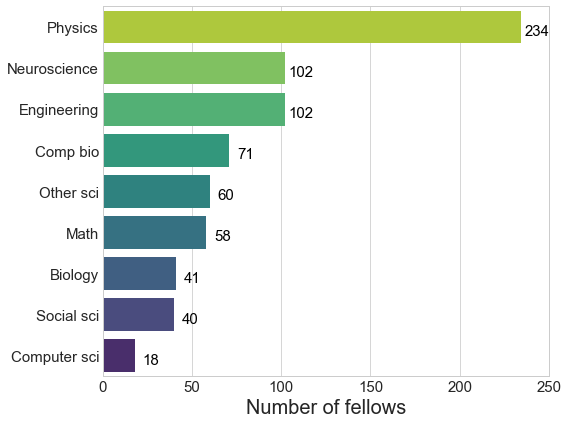

In [13]:
# Plot clumped fields
df_plt = df_fellows['field_clump'].value_counts().reset_index().rename(columns={'field_clump': 'count'})

# Make bar plot
plt.figure(figsize=(8,6))
g=sns.barplot(y='index', x='count', data=df_plt,
            order=df_plt.sort_values(by='count', ascending=False)['index'],
            palette='viridis_r')

for index, row in df_plt.iterrows():
    g.text(row['count'] + 9, row.name + .2,
           row['count'], color='black', ha="center", size=15)

plt.xlabel('Number of fellows', size=20)
plt.ylabel('')
plt.xticks(np.arange(0,300,50), size=15)
plt.xlim((0, 250))
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('/gh/srcole.github.io/assets/insightfellows/academicfields.png')

# 4. Most common institutes

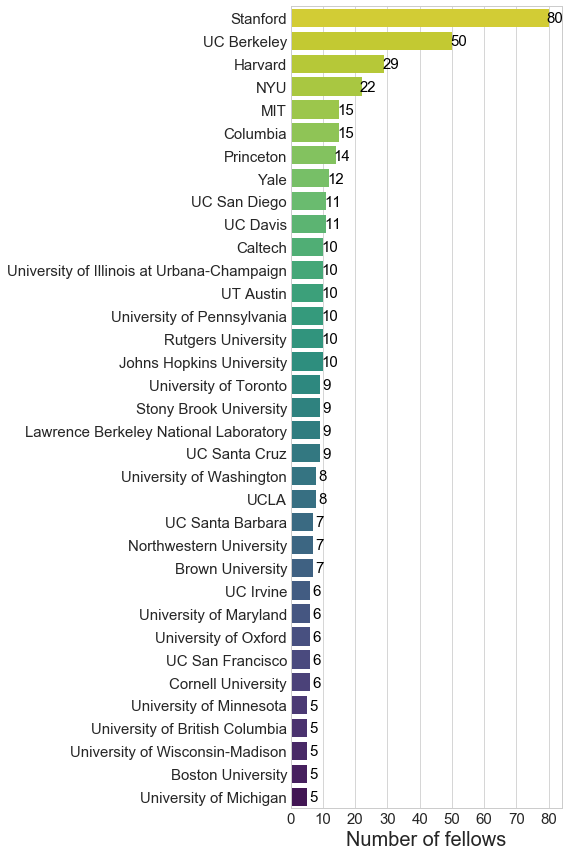

In [14]:
counts = df_fellows['academic_institute'].value_counts()
inst_keep = counts[counts>=5].index
df_plt = df_fellows[df_fellows['academic_institute'].isin(inst_keep)].copy()

plt.figure(figsize=(8,12))
g=sns.countplot(y='academic_institute', data=df_plt, order=inst_keep, palette='viridis_r')

valuecounts = pd.DataFrame(df_plt['academic_institute'].value_counts()).reset_index()
for index, row in valuecounts.iterrows():
    g.text(row['academic_institute'] + 2, row.name + .2,
           row['academic_institute'], color='black', ha="center", size=15)

plt.xlabel('Number of fellows', size=20)
plt.ylabel('')
plt.xticks(np.arange(0,90,10), size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('/gh/srcole.github.io/assets/insightfellows/universities.png')

# 5. Distribution of academic positions

In [15]:
df_temp = df_fellows.dropna()
for pos in ['PhD', 'Postdoc']:
    print('{:.0f}% ({:d}/{:d}) {:s}'.format((df_temp['academic_position']==pos).mean()*100,
                                           (df_temp['academic_position']==pos).sum(),
                                           len(df_temp), pos))

65% (472/726) PhD
29% (211/726) Postdoc


# 6. Keywords of Insight projects

(-0.5, 1199.5, 599.5, -0.5)

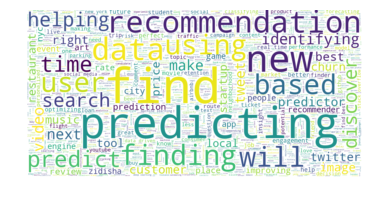

In [16]:
all_projects = ' '.join(df_fellows['insight_project'].values.astype(str)).lower()
wc = WordCloud(background_color="white", max_words=2000, stopwords=set(STOPWORDS),
               width=1200, height=600, random_state=0)
wc.generate(all_projects)
wc.to_file('/gh/srcole.github.io/assets/insightfellows/wordcloud.png')

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# 7. Crosstab analysis

### Crosstab Findings
* Postdocs make up roughly 1/3 of fellows
    * but they are more common at NYU (1/2 of fellows)
    * but they make up over 2/5 of neuroscientists, and less than 20% of social scientists and engineers
    * Postdocs have a higher chance of being in a senior position afterward (47/211 vs. 78/472)
    * Postdocs more likely to do twitter projects (14/25 twitter projects)
* NYU, UC Davis, and Penn disproportionately give neuroscientists
    * Penn also disproportionately gives social scientists
* Roughly 20% of fellows have a nonsenior position, but
    * 7/10 fellows from Caltech have senior positions
    * 5/10 fellows from UIUC have senior positions
* Harvard and Columbia have a dispropotionate number of "finding" projects
* Biologists tend to be senior and mathematicians do not
* Neuroscientists tend to go to Insight (fail?)
    * Square takes physicists
    * Facebook samples equally across fields
* Employees at Facebook and Gartner are not senior
    * Employees at insight are all senior
    * 1/3 of linkedin are senior
    * 1/2 at netflix are senior
* StitchFix and Yelp like people who "Find"

In [17]:
# Define values of interest for each feature
cols = ['academic_position', 'academic_institute', 'field_clump', 'seniority', 'company',
        'project_method', 'project_field']
feat_vals_ct = {}
for col in cols:
    counts = df_fellows[col].value_counts()
    feat_vals_ct[col] = list(counts[counts>=10].index)

# Make crosstabs
for pair in itertools.combinations(cols, 2):
    # Restrict crosstab dataframe to rows which have common values
    # for the two columns of interest (i.e. at least 10 occurrences)
    df_temp = df_fellows[df_fellows[pair[0]].isin(feat_vals_ct[pair[0]])]
    df_temp = df_temp[df_temp[pair[1]].isin(feat_vals_ct[pair[1]])]
    
    # Restrict crosstab dataframe for at least 10 occurrences after first filter
    counts = df_temp[pair[0]].value_counts()
    df_temp = df_temp[df_temp[pair[0]].isin(list(counts[counts>=10].index))]
    
    counts2 = df_temp[pair[1]].value_counts()
    df_temp = df_temp[df_temp[pair[1]].isin(list(counts2[counts2>=10].index))]
    
    
    if (len(list(counts[counts>=10].index)) < 2) or (len(list(counts2[counts2>=10].index)) < 2):
        print('No crosstab available for', pair[0], 'and', pair[1], '\n\n')
        pass
    else:
        # Print crosstab
        print(pd.crosstab(df_temp[pair[0]], df_temp[pair[1]], margins=True).T, '\n\n')


academic_position                           PhD  Postdoc  All
academic_institute                                           
Columbia                                      8        6   14
Harvard                                      23        6   29
MIT                                          10        3   13
NYU                                          10       11   21
Princeton                                     9        5   14
Rutgers University                            6        4   10
Stanford                                     50       26   76
UC Berkeley                                  35       14   49
UC Davis                                      7        4   11
UC San Diego                                  8        3   11
UT Austin                                     9        1   10
University of Illinois at Urbana-Champaign    8        2   10
University of Pennsylvania                    6        4   10
Yale                                          7        4   11
All     

field_clump    Biology  Comp bio  Computer sci  Engineering  Math  \
project_field                                                       
Twitter              2         3             1            3     4   
Yelp                 1         6             0            5     4   
other               38        62            17           94    50   
All                 41        71            18          102    58   

field_clump    Neuroscience  Other sci  Physics  Social sci  All  
project_field                                                     
Twitter                   2          4        6           1   26  
Yelp                      2          7       16           3   44  
other                    98         49      212          36  656  
All                     102         60      234          40  726   


seniority             not senior  senior  All
company                                      
Facebook                      53       1   54
Gartner                       12       0  

### Formalize crosstab findings

In [18]:
df_nyu = df_fellows[df_fellows['academic_institute']=='NYU']
print('Percentage of fellows that are postdocs: {:.0f}%'.format(
    100*(df_fellows['academic_position']=='Postdoc').mean()))
print('Percentage of fellows that are postdocs: {:.0f}%'.format(
    100*(df_nyu['academic_position']=='Postdoc').mean()))

Percentage of fellows that are postdocs: 27%
Percentage of fellows that are postdocs: 50%


In [19]:
df_postdoc = df_fellows[df_fellows['academic_position']=='Postdoc']
df_phd = df_fellows[df_fellows['academic_position']=='PhD']
print('Percentage of phd fellows that have senior positions: {:.0f}%'.format(
    100*(df_phd['seniority']=='senior').mean()))
print('Percentage of postdoc fellows that have senior positions: {:.0f}%'.format(
    100*(df_postdoc['seniority']=='senior').mean()))

Percentage of phd fellows that have senior positions: 17%
Percentage of postdoc fellows that have senior positions: 22%


In [20]:
print('Percentage of phd fellows that did twitter projects: {:.0f}%'.format(
    100*(df_phd['project_field']=='Twitter').mean()))
print('Percentage of postdoc fellows that did twitter projects: {:.0f}%'.format(
    100*(df_postdoc['project_field']=='Twitter').mean()))

Percentage of phd fellows that did twitter projects: 2%
Percentage of postdoc fellows that did twitter projects: 7%


In [21]:
df_neuro = df_fellows[df_fellows['field_clump']=='Neuroscience']
df_engineer = df_fellows[df_fellows['field_clump']=='Engineering']
df_socsci = df_fellows[df_fellows['field_clump']=='Social sci']
print('Percentage of neuro fellows that are postdocs: {:.0f}%'.format(
    100*(df_neuro['academic_position']=='Postdoc').mean()))
print('Percentage of engineering fellows that are postdocs: {:.0f}%'.format(
    100*(df_engineer['academic_position']=='Postdoc').mean()))
print('Percentage of social science fellows that are postdocs: {:.0f}%'.format(
    100*(df_socsci['academic_position']=='Postdoc').mean()))

Percentage of neuro fellows that are postdocs: 42%
Percentage of engineering fellows that are postdocs: 16%
Percentage of social science fellows that are postdocs: 15%


In [22]:
df_bio = df_fellows[df_fellows['field_clump']=='Biology']
df_math = df_fellows[df_fellows['field_clump']=='Math']
print('Percentage of bio fellows that have senior positions: {:.0f}%'.format(
    100*(df_bio['seniority']=='senior').mean()))
print('Percentage of math fellows that have senior positions: {:.0f}%'.format(
    100*(df_math['seniority']=='senior').mean()))

Percentage of bio fellows that have senior positions: 22%
Percentage of math fellows that have senior positions: 10%
